In [2]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
#import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
#from tensorflow_docs.vis import embed

import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow_hub as hub
from keras import layers
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

# Import the MoViNet model from TensorFlow Models (tf-models-official) for the MoViNet model
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model

# Подготавливаем данные

In [47]:
def get_files_per_class(root, dirs_of_classes):
    files_for_class = collections.defaultdict(list)

    for class_dir in dirs_of_classes:
        for f in os.listdir(root + '/' + class_dir):
            full = root + '/' + class_dir + '/' + f

            # чтобы случайно не передали локальную директорию
            path = os.path.normpath(full)
            tokens = path.split(os.sep)
            if len(tokens) >= 2:
                files_for_class[class_dir].append(full)

    return files_for_class

In [48]:
classes = ['normal_behavior', 'loweringO2', 'increasingO2']
num_classes = len(classes)

In [49]:
FILES_PER_CLASS = 50

In [50]:
def select_subset_of_classes(files_for_class, classes, num_files_per_class):
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:num_files_per_class]

  return files_subset

In [51]:
def split_class_lists(files_for_class, count):
  split_files = {}
  remainder = {}
  for cls in files_for_class:
    split_files[cls] = files_for_class[cls][:count]
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

In [52]:
def prepare_subsets(files_for_class, splits):
  for v in files_for_class.values():
    random.shuffle(v)

  # {название сплита: {имя класса: [список файлов]}}
  dirs = {}

  for split_name, split_count in splits.items():
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    # TODO скачивать с яндекс диска
    #download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_files

  return dirs

In [53]:
def format_frames(frame, output_size):
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [54]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

In [55]:
class FrameGenerator:
  def __init__(self, split_files, n_frames, training = False):
    self.split_files = split_files
    self.n_frames = n_frames
    self.training = training

    self.class_names = split_files.keys()
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = []
    classes = []
    for cls, files in self.split_files.items():
      for f in files:
        video_paths.append(f)
        classes.append(cls)
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [56]:
files_for_classes = get_files_per_class('/mnt/c/Users/binarycat/YandexDisk/FishMl', classes)
subsets = prepare_subsets(files_for_classes, {"train": 80, "val": 20, "test": 20})

In [57]:
fg = FrameGenerator(subsets['train'], 10, training=True)
frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {classes[label]}")

Shape: (10, 224, 224, 3)
Label: loweringO2


# Настраиваем модель

In [58]:
batch_size = 8
num_frames = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subsets['train'], num_frames, training = True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subsets['test'], num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

In [59]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor([0 0 0 1 0 1 2 2], shape=(8,), dtype=int16)
tf.Tensor([2 1 1 1 0 2 1 1], shape=(8,), dtype=int16)
tf.Tensor([2 1 2 1 2 2 1 1], shape=(8,), dtype=int16)
tf.Tensor([0 0 0 0 2 1 1 0], shape=(8,), dtype=int16)
tf.Tensor([0 2 2 1 1 0 0 2], shape=(8,), dtype=int16)
tf.Tensor([0 0 2 2 1 2 0 2], shape=(8,), dtype=int16)
tf.Tensor([2 2 2 2 0 1 2 0], shape=(8,), dtype=int16)
tf.Tensor([0 2 1 2 1 0 1 1], shape=(8,), dtype=int16)
tf.Tensor([0 0 0 1 1 2 1 2], shape=(8,), dtype=int16)
tf.Tensor([0 0 2 0 1 2 1 0], shape=(8,), dtype=int16)


In [60]:
model_id = 'a0'
resolution = 172

tf.keras.backend.clear_session()

backbone = movinet.Movinet(model_id=model_id)
backbone.trainable = False

# Set num_classes=600 to load the pre-trained weights from the original model
model = movinet_model.MovinetClassifier(backbone=backbone, num_classes=600)
model.build([None, None, None, None, 3])

# Load pre-trained weights
!wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a0_base.tar.gz -O movinet_a0_base.tar.gz -q
!tar -xvf movinet_a0_base.tar.gz
# !wget https://storage.googleapis.com/tf_model_garden/vision/movinet/movinet_a5_base.tar.gz -O movinet_a5_base.tar.gz -q
# !tar -xvf movinet_a5_base.tar.gz

checkpoint_dir = f'movinet_{model_id}_base'
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint = tf.train.Checkpoint(model=model)
status = checkpoint.restore(checkpoint_path)
status.assert_existing_objects_matched()

movinet_a0_base/
movinet_a0_base/checkpoint
movinet_a0_base/ckpt-1.data-00000-of-00001
movinet_a0_base/ckpt-1.index


In [61]:
def build_classifier(batch_size, num_frames, resolution, backbone, num_classes):
  """Builds a classifier on top of a backbone model."""
  model = movinet_model.MovinetClassifier(
      backbone=backbone,
      num_classes=num_classes)
  model.build([batch_size, 50, resolution, resolution, 3])

  return model

In [62]:
model = build_classifier(batch_size, num_frames, resolution, backbone, 10)
resolution

172

In [63]:
num_epochs = 2

loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(loss=loss_obj, optimizer=optimizer, metrics=['accuracy'])

In [64]:
results = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=num_epochs,
                    validation_freq=1,
                    verbose=1)

Epoch 1/2
30/30 [==============================] - 255s 8s/step - loss: 0.6291 - accuracy: 0.7958 - val_loss: 0.1706 - val_accuracy: 0.9833
Epoch 2/2
30/30 [==============================] - 249s 8s/step - loss: 0.1432 - accuracy: 0.9625 - val_loss: 0.0926 - val_accuracy: 0.9833


In [65]:
model.evaluate(test_ds, return_dict=True)

8/8 [==============================] - 50s 6s/step - loss: 0.0629 - accuracy: 0.9833


{'loss': 0.06293412297964096, 'accuracy': 0.9833333492279053}

In [66]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [67]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [68]:
fg = FrameGenerator(subsets['train'], num_frames, training = True)
label_names = list(fg.class_ids_for_name.keys())

8/8 [==============================] - 53s 6s/step


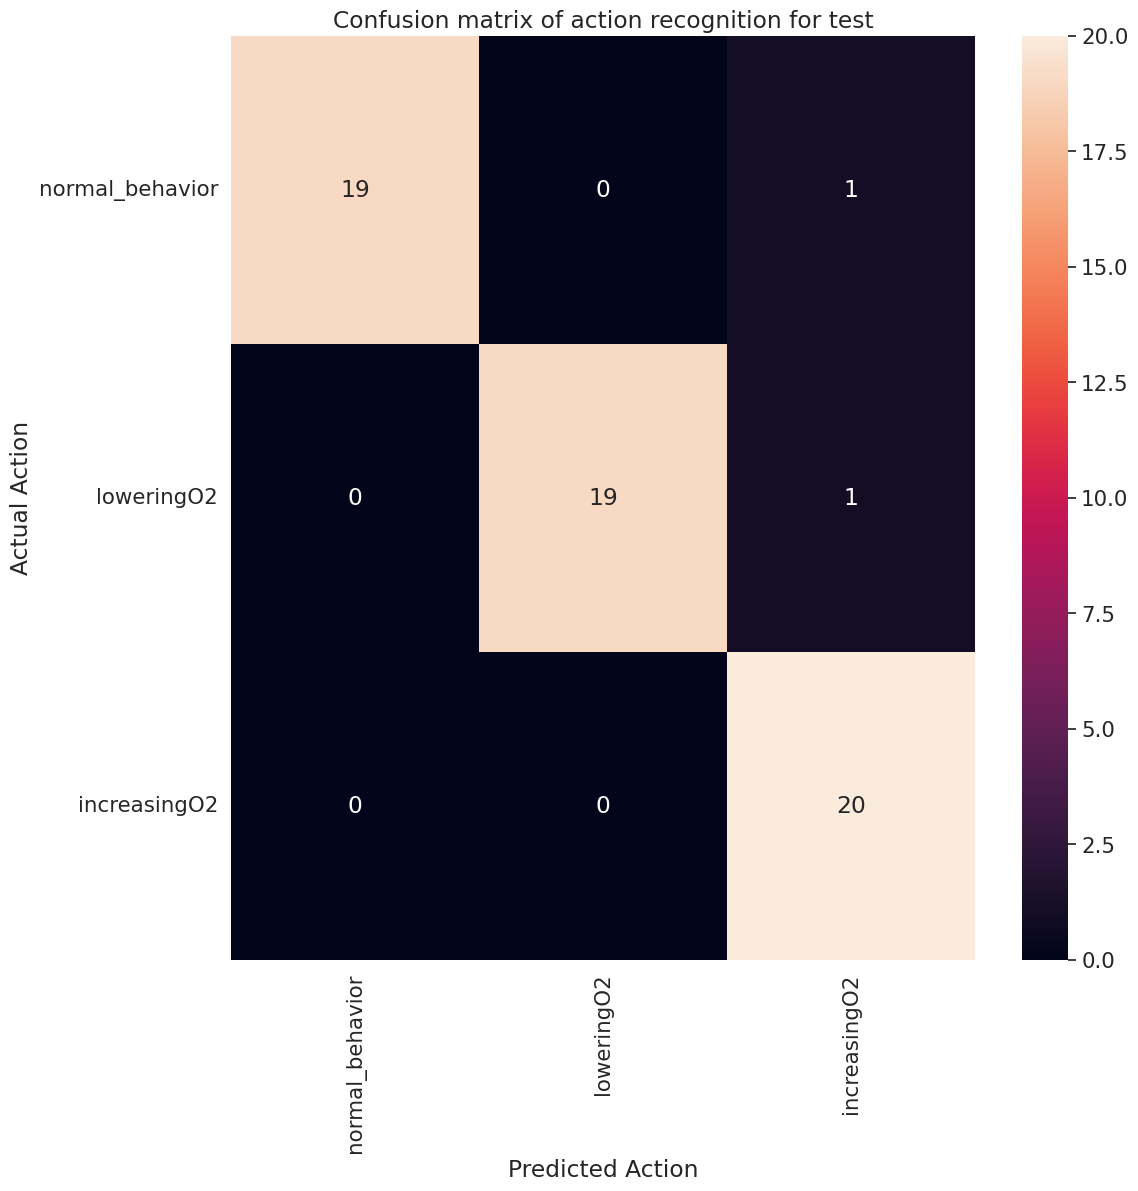

In [69]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, label_names, 'test')